In [ ]:
from google.colab import drive
drive.mount("drive")

In [ ]:
import os
import h5py
import scipy.io
from matplotlib import pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms
from PIL import Image
import zipfile 
import gdown

# Loading converted .npy files to read the utiliy files in the .mat format provided in the repo

In [ ]:

%cd /content

# **CLONING BIOFACENET MATLAB REPOSITORY TO GET ACCESS TO THE MATLAB UTILITY FILES REQUIRED FOR THE FUCNTIONS** : [link text](https://github.com/ssma502/BioFaces.git)

In [ ]:
import os
import gdown
data_root = '/content/Biofacenet_matlab/'
import zipfile 
from zipfile import *
dataset_folder = f'{data_root}/'
download_path = f'{data_root}/'

if not os.path.exists(data_root):
  os.makedirs(data_root)
  os.makedirs(dataset_folder)
os.chdir(data_root)
%pwd
!git clone https://github.com/ssma502/BioFaces.git

# Converting the .mat files into .npy files

In [ ]:
dir = "/content/Biofacenet_matlab/BioFaces/util/"
destination_dir = "/content/Biofacenet_matlab/npy/"

if not os.path.exists(destination_dir):
  os.makedirs(destination_dir)
for files in os.listdir(dir):
  file_mat = scipy.io.loadmat(dir + files)
  file_mat_keys = list(file_mat.keys())
  name = file_mat_keys[3]
  value = file_mat[name]
  np.save(destination_dir + str(name) + ".npy", value )
  globals()[f"{name}"] = np.load(destination_dir+ str(name) + ".npy", allow_pickle = True)

# CONVERTING MATLAB FILES FROM REPO INTO PYTORCH 

# CameraSensitivityPCA.m : 

In [ ]:
from sklearn.decomposition import PCA
def CameraSensitivityPCA(cmf):
  wavelength=33
  cmf = np.moveaxis(cmf, 1, -1)
  cmf /= np.sum(cmf, axis=-1)[..., np.newaxis]
  cmf = np.moveaxis(cmf, -1, 1).reshape((wavelength*3, -1)).T # (3, 33, 28) -> (99, 28) -> (28, 99)
  mu = np.mean(cmf, axis=0) # (99,)
  pca = PCA(n_components=cmf.shape[0]-1 if cmf.shape[0]-1 <= 3*wavelength else cmf.shape[1])
  score = pca.fit_transform(cmf) # (28, 27) = 99 dimensions reduced to 27
  PC = pca.components_ # (27, 99) = linear weights of reduced features based on original features
  cmf -= np.mean(cmf, axis=0)
  cov_matrix = np.dot(cmf.T, cmf) / cmf.shape[0]
  EV = np.array([np.dot(eigenvector.T, np.dot(cov_matrix, eigenvector)) for eigenvector in PC]) # these EVs are already sorted in descending order.
  PC = PC[:2,:].T @ np.diag(np.sqrt(EV[:2])) # take the first two components
  return PC, mu, EV[:2]

PC, mu, EV = CameraSensitivityPCA(np.array(list(rgbCMF[0])))



# cameraModel.m : Sensitivity parameters for the three channels



In [ ]:
def cameraModel(mu, PC, b, wavelength):
  S = b @ PC.T + mu # (B, 2) @ (2, 99) + (99,) -> (B, 99)
  S  = F.relu(S)
  Sr, Sg, Sb = S[:,:wavelength], S[:,wavelength:2*wavelength], S[:,2*wavelength:]
  return Sr, Sg, Sb # (B, 33) ea.

# computelightcolour.m

In [ ]:
def computelightcolour(e, Sr, Sg, Sb):
  lightcolour = torch.stack([torch.sum(Sr* e, dim=1), torch.sum(Sg * e, dim=1), torch.sum(Sb * e, dim=1)], dim=1)
  return lightcolour # (B, 3)

# computeSpecularities.m

In [ ]:
def computeSpecularities(specmask, lightcolour):
  return specmask * lightcolour.unsqueeze(-1).unsqueeze(-1)

# WhiteBalance.m

In [ ]:
def WhiteBalance(rawAppearance, lightcolour):
  ImwhiteBalanced = rawAppearance / lightcolour.unsqueeze(-1).unsqueeze(-1) # (B, 3, H, W) / (B, 3, 1, 1)
  return ImwhiteBalanced # (B, 3, H, W)

# findT.m

In [ ]:
def findT(Tmatrix, BGrid):
  T_raw2xyz = F.grid_sample(input=torch.moveaxis(Tmatrix, -1, 1), 
                            grid=torch.moveaxis(BGrid, 1, -1))
  return T_raw2xyz

# fromRawTosRGB.m

In [ ]:
def fromRawTosRGB(imWB,T_RAW2XYZ):
  # image_white_balanced: (B, 3, H, W)
  # t_raw2xyz: (B, 9, 1, 1)
  Ix = T_RAW2XYZ[:,0] * imWB[:,0] + T_RAW2XYZ[:,3] * imWB[:,1] + T_RAW2XYZ[:,6] * imWB[:,2] # (B, H, W)
  Iy = T_RAW2XYZ[:,1] * imWB[:,0] + T_RAW2XYZ[:,4] * imWB[:,1] + T_RAW2XYZ[:,7] * imWB[:,2]
  Iz = T_RAW2XYZ[:,2] * imWB[:,0] + T_RAW2XYZ[:,5] * imWB[:,1] + T_RAW2XYZ[:,8] * imWB[:,2]
  Ixyz = torch.stack([Ix,Iy, Iz], dim=1) # (B, 3, H, W)
  Txyzrgb  = torch.FloatTensor([3.2406, -0.9689, 0.0557, -1.5372, 1.8758, -0.2040, -0.4986, 0.0415, 1.057])
  R = Txyzrgb[0] * Ixyz[:,0] + Txyzrgb[3] * Ixyz[:,1] + Txyzrgb[6] * Ixyz[:,2] # (B, H, W) * (1,) -> (B, H, W)
  G = Txyzrgb[1] * Ixyz[:,0] + Txyzrgb[4] * Ixyz[:,1] + Txyzrgb[7] * Ixyz[:,2]
  B = Txyzrgb[2] * Ixyz[:,0] + Txyzrgb[5] * Ixyz[:,1] + Txyzrgb[8] * Ixyz[:,2]
  sRGBim = torch.stack([R,G,B], dim=1) # (B, 3, H, W)
  return F.relu(sRGBim)

# BiotoSpectralRef.m

In [ ]:
def BiotoSpectralRF(fmel, fblood,Newskincolour):
  import torch.nn.functional as F
  """
  fmel             : B, 1, H, W
  fblood           : B, 1, H, W
 Newskincolour    : B, 33, 256, 256
  """
  BiophysicalMaps= torch.cat((fmel, fblood), dim=1).permute(0,2,3,1) # (b,2,h,w) -> (b,h,w,2)
  # Uncomment the line below if fmel and fblood are flipped, since grid_sample's docs don't explain if the grid is x,y or y,x ordered.
  # BiophysicalMaps[..., 0], BiophysicalMaps[..., 1] = BiophysicalMaps[..., 1], BiophysicalMaps[..., 0]
  
  R_total = F.grid_sample(input=Newskincolour, grid=BiophysicalMaps)
  return R_total# (B, 33, H, W)

# ImageFormation.m

In [ ]:
def ImageFormation(R_total, Sr, Sg, Sb, e, specularities, shading):
  # srgb: (B, 33) ea.
  # R_total: (B, 33, H, W)
  # e: (B, 33)
  # specularities: (B, C, H, W) where C is 1 or 3.
  # shading: (B, 1, H, W)
  spectraRef = R_total * e.unsqueeze(-1).unsqueeze(-1) # (B, 33, H, W) * (B, 33)
  rChannel = torch.sum(spectraRef * Sr.unsqueeze(-1).unsqueeze(-1), dim=1, keepdim=True) # (B, 33, H, W) * (B, 33) sum -> (B, 1, H, W)
  gChannel = torch.sum(spectraRef * Sg.unsqueeze(-1).unsqueeze(-1), dim=1, keepdim=True)
  bChannel= torch.sum(spectraRef * Sb.unsqueeze(-1).unsqueeze(-1), dim=1, keepdim=True)
  diffuseAlbedo= torch.cat([rChannel, gChannel, bChannel], dim=1) # (B, 3, H, W)
  ShadedDiffuse = diffuseAlbedo * shading # (B, 3, H, W) * (B, 1, H, W) -> (B, 3, H, W)
  # diag(e) i_d r + diag(e) i_s
  rawAppearance = ShadedDiffuse + specularities
  return rawAppearance, diffuseAlbedo

# scalingNet.m

In [ ]:
def scaling(lighting,b,fmel,fblood,shading,specmask,b_size):
  softmax = nn.Softmax(dim = 1)
  sigmoid = nn.Sigmoid()

  lighting_weight = softmax(lighting[:,:-1])
  weightA = lighting_weight[:,0]
  weightD = lighting_weight[:,1]
  Fweights = lighting_weight[:,2:]
  CCT = lighting[:,14]
  CCT = ((22 - 1) / (1 + torch.exp(-CCT)))

  b = 6 * sigmoid(b) - 3
  b = b/3

  fmel = (sigmoid(fmel)*2) - 1
  fblood = (sigmoid(fblood)*2) - 1
  shading = torch.exp(shading)
  specmask = torch.exp(specmask)

  return weightA,weightD,CCT,Fweights,b,fmel,fblood,shading,specmask

# illuminationModel.m

In [ ]:
def illuminationModel(weightA , weightD, Fweights CCT, illum_a, illum_d_norm, illum_f_norm):
  illuminant_a = illum_a * weightA.unsqueeze(-1) # (B, 33) * (B, 1) -> (B, 33)
  # cannot determine from the paper how to use CCT (B) with illumDnorm to calculate illuminant_d.
  # since there are 22 illum_d_norms and color temperature ranges in 4K to 25K, illum_d_norm may be indexed by the nearest K
  # instead of rounding, another idea is to interpolate.
  illuminant_d = (illum_d_norm[:,torch.round(CCT).long()] * weightD).permute(1, 0) # (33, 22[sel B]) (B) -> (33, B) -> (B, 33)
  # illum_f_norm: (33, 12) * Fweights: (B, 12) -> (B, 33, 12)
  illuminant_f = torch.stack([illum_f_norm * f_weight for f_weight in Fweights])
  illuminant_f = torch.sum(illuminant_f, dim=2) # (B, 33)
  e = illuminant_a + illuminant_d + illuminant_f # (B, 33)
  e /= torch.sum(e, dim=0) # (B, 33) / (33) -> (B, 33)
  return e


# **MODEL**

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
class UNet(nn.Module):

  def __init__(self, filters, light_vector_size=15, n_class=4, b_size=2, add_double_conv=True, copy_shading=False):
    super(UNet, self).__init__()
    filters = [3] + filters # filter sizes to apply. [3] is the first in_channels which is always 3 because the input is RGB.
    self.copy_shading = copy_shading # instead of learning a shading map, it copies the B&W image (used for diagnostics)
    self.filters = filters
    self.light_vector_size = light_vector_size
    self.b_size = b_size
    self.n_class = n_class
    self.base = lambda in_channels, out_channels: nn.Sequential(
      nn.Conv2d(in_channels, out_channels, kernel_size=(3, 3), padding=1),
      nn.BatchNorm2d(out_channels, eps=1e-04), # eps to meet MATLAB's batchnorm.
      nn.ReLU()
    )
    self.extra_conv = lambda channels: nn.Sequential(        
      nn.Conv2d(channels, channels, kernel_size=(3, 3), padding=1),
      nn.BatchNorm2d(channels, eps=1e-04),
      nn.ReLU()
    )
    self.light_and_b_layer = nn.Sequential(
      nn.Conv2d(filters[-1], filters[-1], kernel_size=(4,4)),
      nn.BatchNorm2d(filters[-1], eps=1e-04),
      nn.ReLU(),
      nn.Conv2d(filters[-1], filters[-1], kernel_size=(1,1)),
      nn.BatchNorm2d(filters[-1], eps=1e-04),
      nn.ReLU(),
      nn.Conv2d(filters[-1], light_vector_size+b_size, kernel_size=(1, 1))
    )
    
    # Encoder layers
    self.encoder_layers = []
    for i in range(1, len(filters)):
      layer = nn.Sequential(self.base(filters[i-1], filters[i]), self.extra_conv(filters[i]), self.extra_conv(filters[i])) if add_double_conv else self.base(filters[i-1], filters[i])
      self.encoder_layers.append(layer)
    
    # Decoder layers
    self.decoder_layers_by_class = []
    for i in range(n_class):
      decoder_layers = [nn.Conv2d(self.filters[1], 1, kernel_size=(3, 3), padding=1)]
      for i in range(1, len(filters)-1): # start from 1 in order to exclude the [3] we prepended.
        layer = nn.Sequential(self.base(filters[i]+filters[i+1], filters[i]), self.extra_conv(filters[i]), self.extra_conv(filters[i])) if add_double_conv else self.base(filters[i]+filters[i+1], filters[i])
        decoder_layers.append(layer)
      self.decoder_layers_by_class.append(decoder_layers)
  
  # MATLAB file says fmel fblood shading, spec_mask should be 224 x 224 but yours is 64 x 64
  def scale_fmel(self, fmel):
    return torch.sigmoid(fmel) * 2 - 1
  
  def scale_fblood(self, fblood):
    return torch.sigmoid(fblood) * 2 - 1
  
  def scale_shading(self, shading):
    return torch.exp(shading)

  def scale_spec_mask(self, spec_mask):
    return torch.exp(spec_mask)

  def scale_b(self, b):
    return 6 * torch.sigmoid(b) - 3 

  def get_b_grid(self, scaled_b):
    return scaled_b.reshape(-1, self.b_size, 1, 1) / 3
  
  def get_lighting_weights(self, lighting_parameters):
    CCT = lighting_parameters[:,14]
    lighting_weights = F.softmax(lighting_parameters[:,:14], dim=1)
    weightA = lighting_weights[:,0]
    weightD= lighting_weights[:,1]
    Fweights = lighting_weights[:,2:14]
    CCT = ((22-1) / (1 + torch.exp(-CCT))) # removed +1 since it's used as an indexer. it's now between [0-21].
    return weightA, weightD, Fweights, CCT

  def forward(self, x_original):
    # Encode
    x = x_original
    x_skip = []
    for i in range(1, len(self.filters)):
      x = self.encoder_layers[i-1](x)
      if i != len(self.filters)-1:
        x_skip.append(x)
        x = F.max_pool2d(x, kernel_size=(2, 2), stride=2)
    y = x


    # Decode
    predictions = []
    for c in range(self.n_class):
      # print("----class----")
      for i in range(len(self.filters)-2, -1, -1):
          if i > 0:
            x = F.interpolate(y if i == len(self.filters)-2 else x, scale_factor=2, mode='bilinear', align_corners=True)
            x = torch.cat([x, x_skip[i-1]], dim=1)
          x = self.decoder_layers_by_class[c][i](x)
      predictions.append(x)
    fmel, fblood, shading, spec_mask = predictions

    if self.copy_shading:
      shading = torchvision.transforms.Grayscale()(x_original) / 255

    # Fully connected layers? (that's what they call it in the MATLAB repo)
    light_and_b_prediction = self.light_and_b_layer(y)
    light_prediction = light_and_b_prediction[:,:self.light_vector_size,...]
    b_prediction = light_and_b_prediction[:,self.light_vector_size:,...]

    weightA, weightD, Fweights, CCT = self.get_lighting_weights(light_prediction.squeeze(-1).squeeze(-1))
    b_prediction = b_prediction.squeeze(-1).squeeze(-1)
    scaled_b_prediction = self.scale_b(b_prediction)
    b_grid = self.get_b_grid(scaled_b_prediction)

    return {
      "light_prediction": light_prediction,
      "b_prediction": scaled_b_prediction,
      "b_grid": b_grid,
      "weightA": weightA, "weightD": weightD, "Fweights": Fweights, "CCT": CCT,
      "fmel": self.scale_fmel(fmel), "fblood": self.scale_fblood(fblood), "predicted_shading": self.scale_shading(shading), "spec_mask": self.scale_spec_mask(spec_mask)
    }

def unet_test():
  x = torch.FloatTensor(16, 3, 64, 64)
  model = UNet(filters=[32, 64, 128, 256, 512])
  print([(key, value.shape) for key, value in model(x).items()])

unet_test()

[('light_prediction', torch.Size([16, 15, 1, 1])), ('b_prediction', torch.Size([16, 2])), ('b_grid', torch.Size([16, 2, 1, 1])), ('weightA', torch.Size([16])), ('weightD', torch.Size([16])), ('Fweights', torch.Size([16, 12])), ('CCT', torch.Size([16])), ('fmel', torch.Size([16, 1, 64, 64])), ('fblood', torch.Size([16, 1, 64, 64])), ('predicted_shading', torch.Size([16, 1, 64, 64])), ('spec_mask', torch.Size([16, 1, 64, 64]))]


# **1) Training on AUGMENTED CelebA dataset**

# **Loss Calculation for : prior loss, appearance loss, specularity loss and shading loss**

In [ ]:
blossweight = 1e-4  
appweight = 1e-3
Shadingweight = 1e-5
sparseweight = 1e-5 

def loss_calculation(images, rgbim, predictedShading, actualshading, actualmasks, specularities, b_prediction):
  # (16, 3, 1, 1) due to ((16, 3, 256, 256) * (16, 1, 256, 256) -> (16, 3, 1, 1)) / ((16, 1, 256,256)**2 -> (16, 1, 1, 1))
  scale = torch.sum(actualshading * predictedShading *actualmasks, dim=(-1, -2), keepdim=True) / torch.sum(predictedShading * predictedShading *actualmasks, dim=(-1, -2), keepdim=True)
  # (16, 1, 256, 256) due to (16, 1, 256, 256) * (16, 1, 1, 1)
  predictedShading = predictedShading * scale
  # (16, 3, 256, 256)
  alpha = (actualshading - predictedShading) *actualmasks
  # print("shading diff:", alpha.min(), alpha.max())
  appweight, blossweight, Shadingweight, sparseweight = 1e-3, 1e-4, 1e-5, 1e-5
  delta = (images - rgbim) *actualmasks
  # print("image diff:", delta.min(), delta.max())
  appearance_loss = appweight * torch.sum(delta**2) / (images.shape[-1] * images.shape[-2])
  b_loss = blossweight * torch.sum(b_prediction**2)
  shading_loss = Shadingweight * torch.sum(alpha**2)
  sparsity_loss = sparseweight * torch.sum(specularities)
  return b_loss , appearance_loss , shading_loss , sparsity_loss

# **TRAINING**

In [ ]:
%cd "/content/Biofacenet_matlab/npy"

# **DATASET LOADER FOR AUGMNENTED DATASET**

In [ ]:
%cd /content


In [ ]:
# Dataset link from https://github.com/zhixinshu/NeuralFaceEditing
if not os.path.exists("NeuralFaceEditingDataset"):
  os.mkdir("NeuralFaceEditingDataset")
  os.chdir("NeuralFaceEditingDataset")
  !gdown --id 1LjXVghcSLk18JQxmu6iu2mYGaRveoYS3
  !gdown --id 1j0yWt0VJHDNZRTKHQnQo3nQLATvY0z-O
  !gdown --id 1KFn4TYsup0srjc0yAuYRPouA4mpTSUb2
  !gdown --id 1IbLNiPmi6UqBAZQC2dO2r5keljMCKpbn
  !gdown --id 1tBYPjV4D-SiMOONmF4fwmV5pD_XS4Ury
  !gdown --id 1BcMqUrAwDe2r0uTgdWyPYRZP6_KOVodO
  !gdown --id 1puzmuG_zA9u7FdNT3RUabLRmP9A-hHBd
  !gdown --id 1G4SHb3RJiv7coyeXBisU854sPIa0mbZ_
  !gdown --id 1LlH0XSO5a8PzaorOE66Shtk2MpqCYsKr
  !gdown --id 12EXVMH2Xs5qJIO618tFk7BF_6iK43uIG
  !gdown --id 1VzJyRmwVYX8c5DZd30CQmtXZdxZcf3vV
  !gdown --id 1MC4fCRDzoB58u3sQKi1X1t9AFHwFLKso
  !gdown --id 1t4j47DtLtKmyO7khhOqzXsc1ebtyYHlK
  !gdown --id 1aLPvtebfzXIqSypTNWQYCwy1TAjQLLMj
  !gdown --id 1ie9ucPvheNa6YyeMMDl4J1b1NTtrkn-H
  !gdown --id 18N4sYJcvU2A3hFmz1QYN9TV_bWu34XGh
  os.chdir("..")
if not os.path.exists("/tmp/NeuralFaceEditingDataset"):
  os.makedirs("/tmp", exist_ok=True)
  !cp -r NeuralFaceEditingDataset /tmp/NeuralFaceEditingDataset

In [ ]:

class CelebADataset(torch.utils.data.Dataset):
  def __init__(self, dataset_root_path="NeuralFaceEditingDataset", small=False):
    self.small = small
    self.image_tensor, self.light_tensor = self._read_dataset(dataset_root_path)

  def _read_dataset(self, dataset_root_path):
    """
    Read the files of NeuralFaceEditingDataset, validate their properties, and combine them into a single dataset
    """
    files = [f for f in os.listdir(dataset_root_path)]
    image_files = [os.path.abspath(os.path.join(dataset_root_path, f)) for f in sorted(os.listdir(dataset_root_path)) if "inmc_celebA" in f]
    light_files = [os.path.abspath(os.path.join(dataset_root_path, f)) for f in sorted(os.listdir(dataset_root_path)) if "lrgb_celebA" in f]
    assert len(image_files) == len(light_files), "number of image hdf5 files and the number of light hdf5 files mismatch"
    image_tensors = [h5py.File(os.path.join(dataset_root_path, image_file), 'r')["zx_7"] for image_file in image_files]
    light_tensors = [h5py.File(os.path.join(dataset_root_path, light_file), 'r')["zx_7"] for light_file in light_files]
    for image_tensor, light_tensor in zip(image_tensors, light_tensors):
      assert image_tensor.shape[0] == light_tensor.shape[0], "image/light file pair doesn't have the same number of samples"
      assert image_tensor.shape[1] == 10, "image data doesn't have 10 channels"
      assert tuple(light_tensor.shape[-2:]) == (3, 9), "light harmonics data is not in expected shape of (3,9)"
    image_tensor = self._concatenate_h5py_datasets(image_files, "zx_7", "/content/imagedata.h5")
    light_tensor = self._concatenate_h5py_datasets(light_files, "zx_7", "/content/lightdata.h5")
    assert np.equal(image_tensor[image_tensors[0].shape[0]], image_tensors[1][0]).all(), "first frame of second tensor is not properly positioned in the combined dataset"
    assert np.equal(image_tensor[-1], image_tensors[-1][-1]).all(), "last image is not properly positioned in the combined dataset"
    assert image_tensor.shape[0] == light_tensor.shape[0], "the image and light tensors do not have 1 to 1 sample correspondence"
    return image_tensor, light_tensor
  
  # adapted from official h5py examples
  def _concatenate_h5py_datasets(self, file_paths_to_concatenate, entry_key, destination_path):
    """
    Combines h5py files of shape (a,x,y,z), (b,x,y,z), (c,x,y,z) into (a+b+c,x,y,z) and returns the tensor pointer.
    """
    number_of_samples = [h5py.File(f, 'r')[entry_key].shape[0] for f in file_paths_to_concatenate]
    total_number_of_samples = sum(number_of_samples)
    sample_shape = h5py.File(file_paths_to_concatenate[0], 'r')[entry_key].shape[1:] # shape of a single sample
    layout = h5py.VirtualLayout(shape=(total_number_of_samples,) + sample_shape, dtype=np.float64)

    ptr = 0
    for i, source_file_name in enumerate(file_paths_to_concatenate):
      vsource = h5py.VirtualSource(source_file_name, entry_key, shape=(number_of_samples[i],) + sample_shape)
      layout[ptr:ptr+number_of_samples[i]] = vsource
      ptr += number_of_samples[i]
    assert ptr == total_number_of_samples, "dataset not combined properly"

    if os.path.exists(destination_path):
      os.remove(destination_path)
    with h5py.File(destination_path, 'w', libver='latest') as destination_file:
      destination_file.create_virtual_dataset(entry_key, layout)

    return h5py.File(destination_path, 'r')[entry_key]
  
  def _compute_shading(self, normal, light):
    """
    normal: (3, H, W)
    light: (3, 9)
    """
    from skimage import color
    augmented_normal = np.concatenate([normal, np.ones_like(normal[0][np.newaxis, ...])], axis=0) # (4, 64, 64)
    augmented_normal_transposed = np.moveaxis(augmented_normal, 0, -1) # (64, 64, 4)
    shading_responses = []
    for L in light: # compute shading across red, green, blue
      c1, c2, c3, c4, c5 = 0.429043, 0.511664, 0.743125, 0.886227, 0.247708
      K = np.array([[c1*L[8], c1*L[4], c1*L[7], c2*L[3]],
                    [c1*L[4], -c1*L[8], c1*L[5], c2*L[1]],
                    [c1*L[7], c1*L[5], c3*L[6], c2*L[2]],
                    [c2*L[3], c2*L[1], c2*L[2], c4*L[0] - c5*L[6]]])
      # ((64, 64, 4) @ (4, 4)) * (64, 64, 4)
      shading_response = np.sum((augmented_normal_transposed @ K) * augmented_normal_transposed, axis=-1)
      # pass shading through ReLU because it must be nonnegative
      shading_responses.append(np.maximum(shading_response, 0))
    # Uncomment the line below to return RGB shading
    # return np.array(shading_responses)
    # turn shading into grayscale
    return np.moveaxis(color.rgb2gray(np.moveaxis(np.array(shading_responses), 0, -1)), -1, 0)

  def __len__(self):
    return 2 if self.small else self.image_tensor.shape[0]

  def __getitem__(self, idx):
    # original code raises images to the power of 2.2.
    # subtract the average CelebA pixels just like the MATLAB repo.
    image = (255 * (self.image_tensor[idx][:3]**2.2)) - np.array([129.1863,104.7624,93.5940]).reshape((3, 1, 1)) # (3, H, W)
    normal = self.image_tensor[idx][3:6] # (3, H, W)
    mask = self.image_tensor[idx][6][np.newaxis,...] # (1, H, W)
    coord = self.image_tensor[idx][7:] # (3, H, W)
    light = self.light_tensor[idx] # (3, 9)
    shading = self._compute_shading(normal, light) # (H, W)
    return {"image": image, "normal": normal, "mask": mask, "shading": shading, "light": light}

def displayCelebASample(sampleNo):
  item = CelebADataset(dataset_root_path="/tmp/NeuralFaceEditingDataset")[sampleNo]
  print(item["image"].shape, item["normal"].shape, item["mask"].shape, item["shading"].shape, item["light"].shape)
  plt.imshow(np.moveaxis((item["image"] + np.array([129.1863,104.7624,93.5940]).reshape((3, 1, 1)))/255, 0, -1))
  plt.figure()
  plt.imshow(np.moveaxis(item["shading"], 0, -1), cmap='gray')
  plt.figure()
  plt.imshow(item["mask"].squeeze(0), cmap='gray')
  print(item["image"].min(), item["image"].max())

(3, 64, 64) (3, 64, 64) (1, 64, 64) (64, 64) (3, 9)
-128.82085067963365 105.75242283236193


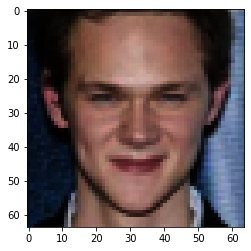

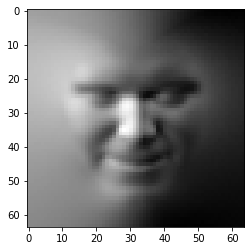

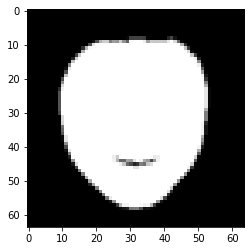

In [ ]:
displayCelebASample(2)


(3, 64, 64) (3, 64, 64) (1, 64, 64) (64, 64) (3, 9)
-128.52691447296027 111.56857404311458


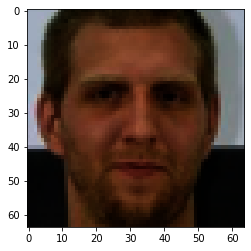

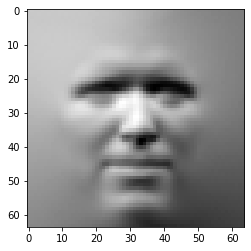

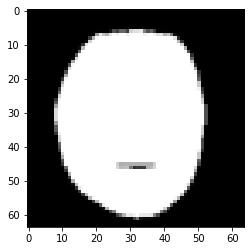

In [ ]:
displayCelebASample(25)

# TRAINING THE MODEL ON AUGEMENTED CelebA DATASET FORM **"Neural Face Editing with Intrinsic Image Disentangling"**



# **TRAINING THE MODEL**

In [ ]:
def decoding_parameters(parameters, illum_a, illum_d_norm, illum_f_norm, PC, mu, EV, wavelength, new_skin_color, t_matrix):
  weightA, weightD, Fweights, CCT, b_prediction, b_grid, fmel, fblood, predicted_shading, spec_mask, light_prediction = parameters["weightA"], parameters["weightD"], parameters["Fweights"], parameters["CCT"], parameters["b_prediction"], parameters["b_grid"], parameters["fmel"], parameters["fblood"], parameters["predicted_shading"], parameters["spec_mask"], parameters["light_prediction"]
  e = illuminationModel(weightA, weightD, Fweights, CCT, illum_a, illum_d_norm, illum_f_norm)
  s_r, s_g, s_b = cameraModel(mu, PC, b_prediction, wavelength)
  light_color = computelightcolour(e, s_r, s_g, s_b)
  specularities = computeSpecularities(spec_mask, light_color)
  r_total = BiotoSpectralRF(fmel, fblood, new_skin_color)
  raw_appearance, diffuse_albedo = ImageFormation(r_total, s_r, s_g, s_b, e, specularities, predicted_shading)
  image_white_balanced = WhiteBalance(raw_appearance, light_color)
  t_raw2xyz = findT(t_matrix, b_grid)
  s_rgb_image = fromRawTosRGB(image_white_balanced, t_raw2xyz)
  return s_rgb_image, predicted_shading, specularities, b_prediction, diffuse_albedo

In [ ]:
small_dataset = True # used for overfitting a small number of images; set to False for 60/20/20 split on 50k images.
learning_rate = 1e-5 # MATLAB repo says 1e-5
batch_size = 2 if small_dataset else 64 # MATLAB repo chooses 64, but we are overfitting a small dataset below.
%cd /content/Biofacenet_matlab
illum_a, illum_d_measured, illum_f,Newskincolour, t_matrix = np.tile(scipy.io.loadmat("BioFaces/util/illumA.mat")["illumA"], (batch_size,1,1)).squeeze(), scipy.io.loadmat("BioFaces/util/illumDmeasured.mat")["illumDmeasured"].reshape(1, 1, 33, 22), scipy.io.loadmat("BioFaces/util/illF.mat")["illF"].reshape(1, 1, 33, 12), np.tile(np.moveaxis(scipy.io.loadmat("BioFaces/util/Newskincolour.mat")["Newskincolour"], -1, 0), (batch_size, 1, 1, 1)), np.tile(scipy.io.loadmat("BioFaces/util/Tmatrix.mat")["Tmatrix"][np.newaxis,...], (batch_size, 1, 1, 1))
illum_a /= np.sum(illum_a)
illum_d_norm = (illum_d_measured / illum_d_measured.sum(axis=-1, keepdims=True)).squeeze()
illum_f_norm = (illum_f / illum_f.sum(axis=-1, keepdims=True)).squeeze()
illum_a, illum_d_norm, illum_f_norm,Newskincolour, t_matrix = torch.from_numpy(illum_a), torch.from_numpy(illum_d_norm), torch.from_numpy(illum_f_norm), torch.from_numpy(Newskincolour), torch.from_numpy(t_matrix)
PC, mu, EV = CameraSensitivityPCA(np.array(list(scipy.io.loadmat("BioFaces/util/rgbCMF.mat")["rgbCMF"][0])))
# PC, mu, EV = torch.from_numpy(scipy.io.loadmat("PC.mat")["PC"]).float(), torch.from_numpy(scipy.io.loadmat("mu.mat")["mu"].flatten()).float(), torch.from_numpy(scipy.io.loadmat("EV.mat")["EV"].flatten()).float()
PC, mu, EV = torch.from_numpy(PC).float(), torch.from_numpy(mu).float(), torch.from_numpy(EV).float()
wavelength = 33

dataset = CelebADataset(dataset_root_path="/content/drive/MyDrive/Colab Notebooks/NeuralFaceEditingDataset/", small=small_dataset)
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')

def display_images(original_image, Srgb_image, predictedShading, specularities, fmel, fblood, diffuseAlbedo,actualmasks):
  from matplotlib import pyplot as plt
  # Srgb_image: (B, 3, H, W), predictedShading: (B, 1, H, W), specularities: (B, 3, H, W), diffuseAlbedo: (B, 3, H, W)
  images_to_display = list(range(0, min(4, original_image.shape[0])))
  for i in images_to_display:
    plt.figure()
    plt.subplot(1, 7, 1)
    # print(f"original min/max {(original_image[i]+ torch.FloatTensor([129.1863,104.7624,93.5940]).reshape((3, 1, 1))*actualmasks[i]).min()} {(original_image[i]+ torch.FloatTensor([129.1863,104.7624,93.5940]).reshape((3, 1, 1))*actualmasks[i]).max()}")
    plt.imshow(np.moveaxis(((original_image[i] + torch.FloatTensor([129.1863,104.7624,93.5940]).reshape((3, 1, 1)) )/255*actualmasks[i]).cpu().detach().numpy().astype(float), 0, -1))
    plt.subplot(1, 7, 2)
    # print(f"reconstruction min/max {(Srgb_image[i]+ torch.FloatTensor([129.1863,104.7624,93.5940]).reshape((3, 1, 1))*actualmasks[i]).min()} {(Srgb_image[i]+ torch.FloatTensor([129.1863,104.7624,93.5940]).reshape((3, 1, 1))*actualmasks[i]).max()}")
    plt.imshow(np.moveaxis(( (Srgb_image[i] + torch.FloatTensor([129.1863,104.7624,93.5940]).reshape((3, 1, 1)) )/255*actualmasks[i]).cpu().detach().numpy().astype(float), 0, -1))
    plt.subplot(1, 7, 3)
    plt.imshow((predictedShading[i]*actualmasks[i]).squeeze(0).cpu().detach().numpy(), cmap='gray')
    plt.subplot(1, 7, 4)
    specularity = np.moveaxis((specularities[i]*actualmasks[i]).cpu().detach().numpy(), 0, -1)
    plt.imshow(specularity / specularity.max())
    plt.subplot(1, 7, 5)
    plt.imshow((fmel[i]).squeeze(0).cpu().detach().numpy(), vmin=-1, vmax=1)
    plt.subplot(1, 7, 6)
    plt.imshow((fblood[i]).squeeze(0).cpu().detach().numpy(), vmin=-1, vmax=1)
    plt.subplot(1, 7, 7)
    plottable_diffuseAlbedo = np.moveaxis((diffuseAlbedo[i]*actualmasks[i]).cpu().detach().numpy(), 0, -1)
    plt.imshow(plottable_diffuseAlbedo / plottable_diffuseAlbedo.max())
    plt.show()


def make_train_val_test_dataloaders(dataset, batch_size):
  from torch.utils.data.sampler import SubsetRandomSampler
  # Could not find dataset split in the experiment section; assuming 60/20/20 split.
  np.random.seed(seed=42)
  all_samples, train_size, val_size = [i for i in range(len(dataset))], (1.0 if small_dataset else 0.6), (0.0 if small_dataset else 0.2)
  np.random.shuffle(all_samples)
  train_samples, val_samples, test_samples = np.split(all_samples, 
                                                        [int(train_size * len(all_samples)), 
                                                        int((train_size + val_size) * len(all_samples))
                                                        ])
  dataloaders = {
      "train": torch.utils.data.DataLoader(dataset, batch_size=batch_size, sampler=SubsetRandomSampler(train_samples), pin_memory=True, drop_last=True),
      "val": torch.utils.data.DataLoader(dataset, batch_size=batch_size, sampler=SubsetRandomSampler(val_samples), pin_memory=True, drop_last=True),
      "test": torch.utils.data.DataLoader(dataset, batch_size=batch_size, sampler=SubsetRandomSampler(test_samples), pin_memory=True, drop_last=True),
  }
  return dataloaders

dataloaders = make_train_val_test_dataloaders(dataset, batch_size)

def train_model(model, dataloaders, optimizers, output_path, device, num_epochs=2000, epoch_start=0, display_condition=None):
  for epoch in range(epoch_start, num_epochs):
    print(f"Epoch {epoch}/{num_epochs-1}")
    
    for phase in ["train", "val"]:
      running_loss, running_b_loss, running_app_loss, running_shading_loss, running_sparsity_loss = 0, 0, 0, 0, 0
      if phase == "train": model.train()
      else: model.eval()

      epoch_size = 0
      for i, batch in enumerate(dataloaders[phase]):
        for optimizer in optimizers: optimizer.zero_grad()
        with torch.set_grad_enabled(phase == "train"):
          outputs = model(batch["image"].float())
          Srgb_image, predictedShading, specularities, b_prediction, diffuseAlbedo = decoding_parameters(outputs, illum_a, illum_d_norm, illum_f_norm, PC, mu, EV, wavelength,Newskincolour, t_matrix)
          scaled_images = batch["image"]
          scaled_rgb = Srgb_image * 255 - torch.FloatTensor([129.1863,104.7624,93.5940]).reshape((1, 3, 1, 1))
          b_loss, appearance_loss, shading_loss, sparsity_loss = loss_calculation(scaled_images, scaled_rgb, predictedShading, batch["shading"], batch["mask"], specularities, b_prediction)
          loss = b_loss + appearance_loss + shading_loss + sparsity_loss
          if phase == "train":
            loss.backward()
            for optimizer in optimizers: optimizer.step()
        epoch_size += outputs["weightA"].shape[0]
        running_loss += loss.item()
        running_b_loss += b_loss.item()
        running_app_loss += appearance_loss.item()
        running_shading_loss += shading_loss.item()
        running_sparsity_loss += sparsity_loss.item()
      if not epoch_size: continue
      if display_condition(phase, epoch):
        display_images(scaled_images, scaled_rgb, predictedShading, specularities, outputs["fmel"].float(), outputs["fblood"].float(), diffuseAlbedo, batch["mask"])
        print(f"{phase} average loss: {(running_loss / epoch_size):.4f}")
        # diffuse i_d, specular i_s, melanin fmel, haemoglobin fblood
        print(f"b_loss: {b_loss}, appearance_loss: {running_app_loss/epoch_size}, shading_loss: {running_shading_loss/epoch_size}, sparsity_loss: {running_sparsity_loss/epoch_size}")

/content/Biofacenet_matlab


Epoch 0/599


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3982: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  "Default grid_sample and affine_grid behavior has changed "


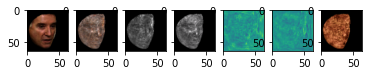

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


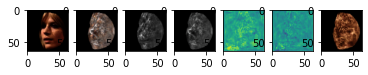

train average loss: 4.1368
b_loss: 0.0002252558624604717, appearance_loss: 4.082533086138634, shading_loss: 0.0016196179976056778, sparsity_loss: 0.052493054419755936
Epoch 1/599
Epoch 2/599
Epoch 3/599
Epoch 4/599
Epoch 5/599
Epoch 6/599
Epoch 7/599
Epoch 8/599
Epoch 9/599
Epoch 10/599
Epoch 11/599
Epoch 12/599
Epoch 13/599
Epoch 14/599
Epoch 15/599
Epoch 16/599
Epoch 17/599
Epoch 18/599
Epoch 19/599
Epoch 20/599
Epoch 21/599
Epoch 22/599
Epoch 23/599
Epoch 24/599
Epoch 25/599
Epoch 26/599
Epoch 27/599
Epoch 28/599
Epoch 29/599
Epoch 30/599


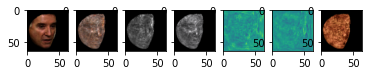

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


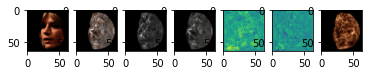

train average loss: 4.0813
b_loss: 0.0004909534472972155, appearance_loss: 4.026878573796835, shading_loss: 0.0016196179976056778, sparsity_loss: 0.05253348499536514
Epoch 31/599
Epoch 32/599
Epoch 33/599
Epoch 34/599
Epoch 35/599
Epoch 36/599
Epoch 37/599
Epoch 38/599
Epoch 39/599
Epoch 40/599
Epoch 41/599
Epoch 42/599
Epoch 43/599
Epoch 44/599
Epoch 45/599
Epoch 46/599
Epoch 47/599
Epoch 48/599
Epoch 49/599
Epoch 50/599
Epoch 51/599
Epoch 52/599
Epoch 53/599
Epoch 54/599
Epoch 55/599
Epoch 56/599
Epoch 57/599
Epoch 58/599
Epoch 59/599
Epoch 60/599


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


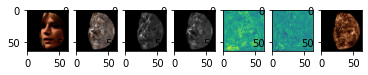

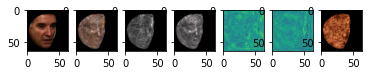

train average loss: 4.0412
b_loss: 0.0008961418643593788, appearance_loss: 3.986297486934517, shading_loss: 0.0016196179976056778, sparsity_loss: 0.05280154198408127
Epoch 61/599
Epoch 62/599
Epoch 63/599
Epoch 64/599
Epoch 65/599
Epoch 66/599
Epoch 67/599
Epoch 68/599
Epoch 69/599
Epoch 70/599
Epoch 71/599
Epoch 72/599
Epoch 73/599
Epoch 74/599
Epoch 75/599
Epoch 76/599
Epoch 77/599
Epoch 78/599
Epoch 79/599
Epoch 80/599
Epoch 81/599
Epoch 82/599
Epoch 83/599
Epoch 84/599
Epoch 85/599
Epoch 86/599
Epoch 87/599
Epoch 88/599
Epoch 89/599
Epoch 90/599


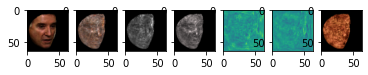

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


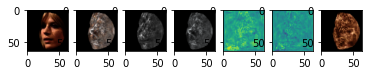

train average loss: 4.0088
b_loss: 0.0010498329065740108, appearance_loss: 3.953661957108769, shading_loss: 0.0016196179976056778, sparsity_loss: 0.05302521958947182
Epoch 91/599
Epoch 92/599
Epoch 93/599
Epoch 94/599
Epoch 95/599
Epoch 96/599
Epoch 97/599
Epoch 98/599
Epoch 99/599
Epoch 100/599
Epoch 101/599
Epoch 102/599
Epoch 103/599
Epoch 104/599
Epoch 105/599
Epoch 106/599
Epoch 107/599
Epoch 108/599
Epoch 109/599
Epoch 110/599
Epoch 111/599
Epoch 112/599
Epoch 113/599
Epoch 114/599
Epoch 115/599
Epoch 116/599
Epoch 117/599
Epoch 118/599
Epoch 119/599
Epoch 120/599


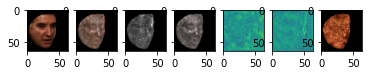

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


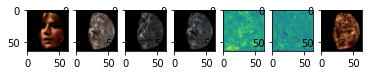

train average loss: 3.9881
b_loss: 0.0012682945234701037, appearance_loss: 3.932521404654527, shading_loss: 0.0016196179976056778, sparsity_loss: 0.053340062499046326
Epoch 121/599
Epoch 122/599
Epoch 123/599
Epoch 124/599
Epoch 125/599
Epoch 126/599
Epoch 127/599
Epoch 128/599
Epoch 129/599
Epoch 130/599
Epoch 131/599
Epoch 132/599
Epoch 133/599
Epoch 134/599
Epoch 135/599
Epoch 136/599
Epoch 137/599
Epoch 138/599
Epoch 139/599
Epoch 140/599
Epoch 141/599
Epoch 142/599
Epoch 143/599
Epoch 144/599
Epoch 145/599
Epoch 146/599
Epoch 147/599
Epoch 148/599
Epoch 149/599
Epoch 150/599


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


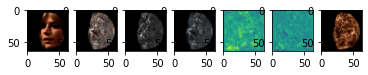

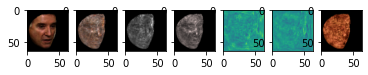

train average loss: 3.9756
b_loss: 0.00149251869879663, appearance_loss: 3.9196630589252672, shading_loss: 0.0016196179976056778, sparsity_loss: 0.053577132523059845
Epoch 151/599
Epoch 152/599
Epoch 153/599
Epoch 154/599
Epoch 155/599
Epoch 156/599
Epoch 157/599
Epoch 158/599
Epoch 159/599
Epoch 160/599
Epoch 161/599
Epoch 162/599
Epoch 163/599
Epoch 164/599
Epoch 165/599
Epoch 166/599
Epoch 167/599
Epoch 168/599
Epoch 169/599
Epoch 170/599
Epoch 171/599
Epoch 172/599
Epoch 173/599
Epoch 174/599
Epoch 175/599
Epoch 176/599
Epoch 177/599
Epoch 178/599
Epoch 179/599
Epoch 180/599


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


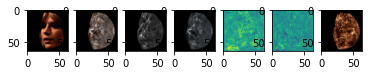

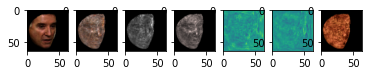

train average loss: 3.9693
b_loss: 0.0016645588912069798, appearance_loss: 3.913158330907439, shading_loss: 0.0016196179976056778, sparsity_loss: 0.053712405264377594
Epoch 181/599
Epoch 182/599
Epoch 183/599
Epoch 184/599
Epoch 185/599
Epoch 186/599
Epoch 187/599
Epoch 188/599
Epoch 189/599
Epoch 190/599
Epoch 191/599
Epoch 192/599
Epoch 193/599
Epoch 194/599
Epoch 195/599
Epoch 196/599
Epoch 197/599
Epoch 198/599
Epoch 199/599
Epoch 200/599
Epoch 201/599
Epoch 202/599
Epoch 203/599
Epoch 204/599
Epoch 205/599
Epoch 206/599
Epoch 207/599
Epoch 208/599
Epoch 209/599
Epoch 210/599


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


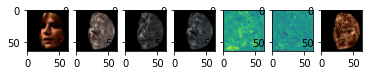

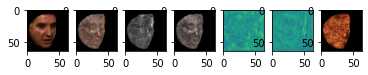

train average loss: 3.9639
b_loss: 0.001759404898621142, appearance_loss: 3.90758461977324, shading_loss: 0.0016196179976056778, sparsity_loss: 0.05384043976664543
Epoch 211/599
Epoch 212/599
Epoch 213/599
Epoch 214/599
Epoch 215/599
Epoch 216/599
Epoch 217/599
Epoch 218/599
Epoch 219/599
Epoch 220/599
Epoch 221/599
Epoch 222/599
Epoch 223/599
Epoch 224/599
Epoch 225/599
Epoch 226/599
Epoch 227/599
Epoch 228/599
Epoch 229/599
Epoch 230/599
Epoch 231/599
Epoch 232/599
Epoch 233/599
Epoch 234/599
Epoch 235/599
Epoch 236/599
Epoch 237/599
Epoch 238/599
Epoch 239/599
Epoch 240/599


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


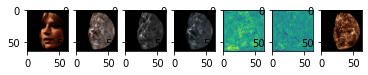

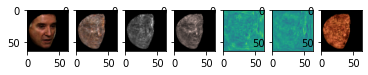

train average loss: 3.9615
b_loss: 0.0017877196660265326, appearance_loss: 3.9051706422244425, shading_loss: 0.0016196179976056778, sparsity_loss: 0.05385931581258774
Epoch 241/599
Epoch 242/599
Epoch 243/599
Epoch 244/599
Epoch 245/599
Epoch 246/599
Epoch 247/599
Epoch 248/599
Epoch 249/599
Epoch 250/599
Epoch 251/599
Epoch 252/599
Epoch 253/599
Epoch 254/599
Epoch 255/599
Epoch 256/599
Epoch 257/599
Epoch 258/599
Epoch 259/599
Epoch 260/599
Epoch 261/599
Epoch 262/599
Epoch 263/599
Epoch 264/599
Epoch 265/599
Epoch 266/599
Epoch 267/599
Epoch 268/599
Epoch 269/599
Epoch 270/599


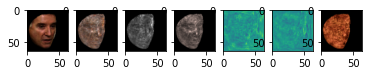

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


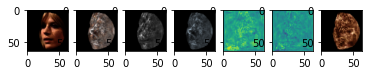

train average loss: 3.9594
b_loss: 0.0018427358008921146, appearance_loss: 3.9029387902270174, shading_loss: 0.0016196179976056778, sparsity_loss: 0.05390293151140213
Epoch 271/599
Epoch 272/599
Epoch 273/599
Epoch 274/599
Epoch 275/599
Epoch 276/599
Epoch 277/599
Epoch 278/599
Epoch 279/599
Epoch 280/599
Epoch 281/599
Epoch 282/599
Epoch 283/599
Epoch 284/599
Epoch 285/599
Epoch 286/599
Epoch 287/599
Epoch 288/599
Epoch 289/599
Epoch 290/599
Epoch 291/599
Epoch 292/599
Epoch 293/599
Epoch 294/599
Epoch 295/599
Epoch 296/599
Epoch 297/599
Epoch 298/599
Epoch 299/599
Epoch 300/599


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


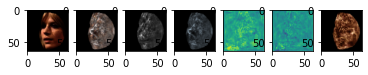

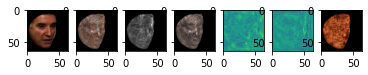

train average loss: 3.9570
b_loss: 0.001887020654976368, appearance_loss: 3.9005336532668275, shading_loss: 0.0016196179976056778, sparsity_loss: 0.053946707397699356
Epoch 301/599
Epoch 302/599
Epoch 303/599
Epoch 304/599
Epoch 305/599
Epoch 306/599
Epoch 307/599
Epoch 308/599
Epoch 309/599
Epoch 310/599
Epoch 311/599
Epoch 312/599
Epoch 313/599
Epoch 314/599
Epoch 315/599
Epoch 316/599
Epoch 317/599
Epoch 318/599
Epoch 319/599
Epoch 320/599
Epoch 321/599
Epoch 322/599
Epoch 323/599
Epoch 324/599
Epoch 325/599
Epoch 326/599
Epoch 327/599
Epoch 328/599
Epoch 329/599
Epoch 330/599


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


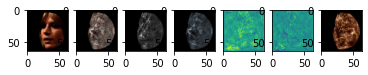

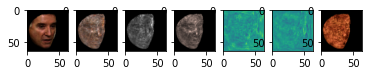

train average loss: 3.9550
b_loss: 0.0019381894962862134, appearance_loss: 3.898460590828687, shading_loss: 0.0016196179976056778, sparsity_loss: 0.053984880447387695
Epoch 331/599
Epoch 332/599
Epoch 333/599
Epoch 334/599
Epoch 335/599
Epoch 336/599
Epoch 337/599
Epoch 338/599
Epoch 339/599
Epoch 340/599
Epoch 341/599
Epoch 342/599
Epoch 343/599
Epoch 344/599
Epoch 345/599
Epoch 346/599
Epoch 347/599
Epoch 348/599
Epoch 349/599
Epoch 350/599
Epoch 351/599
Epoch 352/599
Epoch 353/599
Epoch 354/599
Epoch 355/599
Epoch 356/599
Epoch 357/599
Epoch 358/599
Epoch 359/599
Epoch 360/599


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


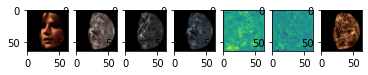

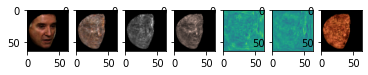

train average loss: 3.9537
b_loss: 0.001970713259652257, appearance_loss: 3.897115511023553, shading_loss: 0.0016196179976056778, sparsity_loss: 0.05400962755084038
Epoch 361/599
Epoch 362/599
Epoch 363/599
Epoch 364/599
Epoch 365/599
Epoch 366/599
Epoch 367/599
Epoch 368/599
Epoch 369/599
Epoch 370/599
Epoch 371/599
Epoch 372/599
Epoch 373/599
Epoch 374/599
Epoch 375/599
Epoch 376/599
Epoch 377/599
Epoch 378/599
Epoch 379/599
Epoch 380/599
Epoch 381/599
Epoch 382/599
Epoch 383/599
Epoch 384/599
Epoch 385/599
Epoch 386/599
Epoch 387/599
Epoch 388/599
Epoch 389/599
Epoch 390/599


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


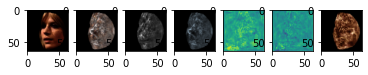

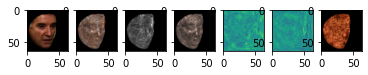

train average loss: 3.9524
b_loss: 0.0019927574321627617, appearance_loss: 3.8957528442155964, shading_loss: 0.0016196179976056778, sparsity_loss: 0.05402858927845955
Epoch 391/599
Epoch 392/599
Epoch 393/599
Epoch 394/599
Epoch 395/599
Epoch 396/599
Epoch 397/599
Epoch 398/599
Epoch 399/599
Epoch 400/599
Epoch 401/599
Epoch 402/599
Epoch 403/599
Epoch 404/599
Epoch 405/599
Epoch 406/599
Epoch 407/599
Epoch 408/599
Epoch 409/599
Epoch 410/599
Epoch 411/599
Epoch 412/599
Epoch 413/599
Epoch 414/599
Epoch 415/599
Epoch 416/599
Epoch 417/599
Epoch 418/599
Epoch 419/599
Epoch 420/599


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


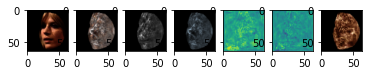

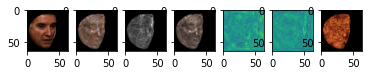

train average loss: 3.9507
b_loss: 0.0020254910923540592, appearance_loss: 3.893962393134012, shading_loss: 0.0016196179976056778, sparsity_loss: 0.05406464263796806
Epoch 421/599
Epoch 422/599
Epoch 423/599
Epoch 424/599
Epoch 425/599
Epoch 426/599
Epoch 427/599
Epoch 428/599
Epoch 429/599
Epoch 430/599
Epoch 431/599
Epoch 432/599
Epoch 433/599
Epoch 434/599
Epoch 435/599
Epoch 436/599
Epoch 437/599
Epoch 438/599
Epoch 439/599
Epoch 440/599
Epoch 441/599
Epoch 442/599
Epoch 443/599
Epoch 444/599
Epoch 445/599
Epoch 446/599
Epoch 447/599
Epoch 448/599
Epoch 449/599
Epoch 450/599


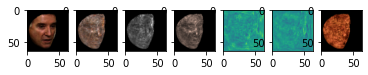

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


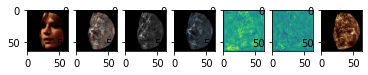

train average loss: 3.9494
b_loss: 0.0020528952591121197, appearance_loss: 3.8926748553257484, shading_loss: 0.0016196179976056778, sparsity_loss: 0.05408211797475815
Epoch 451/599
Epoch 452/599
Epoch 453/599
Epoch 454/599
Epoch 455/599
Epoch 456/599
Epoch 457/599
Epoch 458/599
Epoch 459/599
Epoch 460/599
Epoch 461/599
Epoch 462/599
Epoch 463/599
Epoch 464/599
Epoch 465/599
Epoch 466/599
Epoch 467/599
Epoch 468/599
Epoch 469/599
Epoch 470/599
Epoch 471/599
Epoch 472/599
Epoch 473/599
Epoch 474/599
Epoch 475/599
Epoch 476/599
Epoch 477/599
Epoch 478/599
Epoch 479/599
Epoch 480/599


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


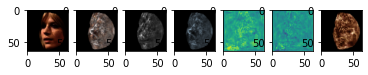

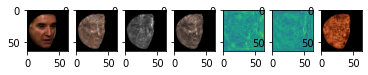

train average loss: 3.9482
b_loss: 0.002075972268357873, appearance_loss: 3.8914705838338493, shading_loss: 0.0016196179976056778, sparsity_loss: 0.05410293862223625
Epoch 481/599
Epoch 482/599
Epoch 483/599
Epoch 484/599
Epoch 485/599
Epoch 486/599
Epoch 487/599
Epoch 488/599
Epoch 489/599
Epoch 490/599
Epoch 491/599
Epoch 492/599
Epoch 493/599
Epoch 494/599
Epoch 495/599
Epoch 496/599
Epoch 497/599
Epoch 498/599
Epoch 499/599
Epoch 500/599
Epoch 501/599
Epoch 502/599
Epoch 503/599
Epoch 504/599
Epoch 505/599
Epoch 506/599
Epoch 507/599
Epoch 508/599
Epoch 509/599
Epoch 510/599


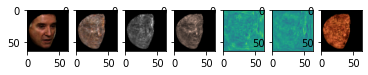

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


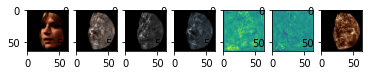

train average loss: 3.9470
b_loss: 0.0020968616008758545, appearance_loss: 3.890232518057227, shading_loss: 0.0016196179976056778, sparsity_loss: 0.05411170795559883
Epoch 511/599
Epoch 512/599
Epoch 513/599
Epoch 514/599
Epoch 515/599
Epoch 516/599
Epoch 517/599
Epoch 518/599
Epoch 519/599
Epoch 520/599
Epoch 521/599
Epoch 522/599
Epoch 523/599
Epoch 524/599
Epoch 525/599
Epoch 526/599
Epoch 527/599
Epoch 528/599
Epoch 529/599
Epoch 530/599
Epoch 531/599
Epoch 532/599
Epoch 533/599
Epoch 534/599
Epoch 535/599
Epoch 536/599
Epoch 537/599
Epoch 538/599
Epoch 539/599
Epoch 540/599


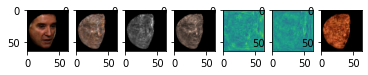

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


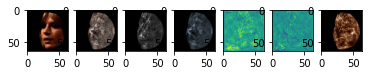

train average loss: 3.9452
b_loss: 0.0021406318992376328, appearance_loss: 3.8884039787082583, shading_loss: 0.0016196179976056778, sparsity_loss: 0.054136257618665695
Epoch 541/599
Epoch 542/599
Epoch 543/599
Epoch 544/599
Epoch 545/599
Epoch 546/599
Epoch 547/599
Epoch 548/599
Epoch 549/599
Epoch 550/599
Epoch 551/599
Epoch 552/599
Epoch 553/599
Epoch 554/599
Epoch 555/599
Epoch 556/599
Epoch 557/599
Epoch 558/599
Epoch 559/599
Epoch 560/599
Epoch 561/599
Epoch 562/599
Epoch 563/599
Epoch 564/599
Epoch 565/599
Epoch 566/599
Epoch 567/599
Epoch 568/599
Epoch 569/599
Epoch 570/599


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


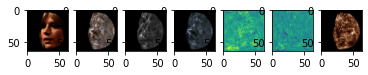

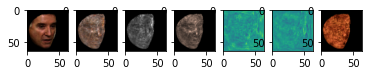

train average loss: 3.9437
b_loss: 0.002178080612793565, appearance_loss: 3.886868061780304, shading_loss: 0.0016196179976056778, sparsity_loss: 0.05416155979037285
Epoch 571/599
Epoch 572/599
Epoch 573/599
Epoch 574/599
Epoch 575/599
Epoch 576/599
Epoch 577/599
Epoch 578/599
Epoch 579/599
Epoch 580/599
Epoch 581/599
Epoch 582/599
Epoch 583/599
Epoch 584/599
Epoch 585/599
Epoch 586/599
Epoch 587/599
Epoch 588/599
Epoch 589/599
Epoch 590/599
Epoch 591/599
Epoch 592/599
Epoch 593/599
Epoch 594/599
Epoch 595/599
Epoch 596/599
Epoch 597/599
Epoch 598/599
Epoch 599/599


In [ ]:
model = UNet(filters=[32,64,128,256,512], light_vector_size=15, n_class=4, b_size=2, add_double_conv=True)
optimizers = [torch.optim.Adam(model.parameters(), lr=learning_rate)]
display_condition = lambda phase, epoch: phase == "train" and epoch % 30 == 0
train_model(model, dataloaders, optimizers, output_path="/tmp", device=device, num_epochs=600, display_condition=display_condition)

In [ ]:
class ISETDataset(torch.utils.data.Dataset):
  def __init__(self, dataset_root_path="ISET", small=False):
    self.small = small
    self.image_files, self.param_files = self.data_reader(dataset_root_path)

  def data_reader(self, dataset_root_path):
    files = [f for f in os.listdir(dataset_root_path)]
    image_files = [os.path.abspath(os.path.join(dataset_root_path, f)) for f in [f"HiResFemale{i}.mat" for i in range(1, 14)] + [f"HiResMale{i}.mat" for i in range(1, 13)]]
    param_files = [os.path.abspath(os.path.join(dataset_root_path, f)) for f in [f"HiResFemale{i}_Params.mat" for i in range(1, 14)] + [f"HiResMale{i}_Params.mat" for i in range(1, 13)]]
    print(image_files)
    print(param_files)
    return image_files, param_files

  def getLength(self):
    return 1 if self.small else len(image_files)

  def getItem(self, idx):
    image = scipy.io.loadmat(self.image_files[idx])
    param = scipy.io.loadmat(self.param_files[idx])
    return {"spectrum": image["mcCOEF"], **{key: value for key, value in image.items() if key != "mcCOEF"}}

def displayISETSample(sampleNo):
  item = ISETDataset(dataset_root_path="/ISET")[sampleNo]
  plt.figure() 
  plt.imshow(item["spectrum"][...,2])
  print(item["spectrum"].shape)

In [ ]:
def decompose_multispectral(multispectral_obs, display_condition=lambda i:True):
  wavelength = 6
  # multispectral_obs has shape (1, 6, H, W)
  _, _, H, W = multispectral_obs.shape
  PC, mu, EV = camera_sensitivity_pca(np.array(list(scipy.io.loadmat("BioFaces/util/rgbCMF.mat")["rgbCMF"][0]))[:,[1,7,13,19,25,31],:], wavelength)
  PC, mu, EV = torch.from_numpy(PC).float(), torch.from_numpy(mu).float(), torch.from_numpy(EV).float()

  class ModelFitting(nn.Module):
    def __init__(self):
      super(ModelFitting, self).__init__()
      self.Shadingweights = torch.nn.Linear(in_features=1, out_features=H*W, bias=False)
      self.specularities_weights = torch.nn.Linear(in_features=1, out_features=3*H*W, bias=False)
      self.fmel_weights = torch.nn.Linear(in_features=1, out_features=H*W, bias=False)
      self.fblood_weights = torch.nn.Linear(in_features=1, out_features=H*W, bias=False)
    
    def scale_shading(self, shading):
      return F.relu(shading) # torch.exp(shading)
    
    def scale_specularities(self, specularities):
      return F.relu(specularities) # torch.exp(specularities)

    def scale_fmel(self, fmel):
      return (43/100 - 1.3/100) * torch.sigmoid(fmel) + 1.3/100

    def scale_fblood(self, fblood):
      return (7/100 - 2/100) * torch.sigmoid(fblood) + 2/100

    def forward(self, x):
      shading = self.scale_shading(self.Shadingweights(x).reshape(1, 1, H, W))
      specularities = self.scale_specularities(self.specularities_weights(x).reshape(1, 3, H, W))
      fmel = self.scale_fmel(self.fmel_weights(x).reshape(1, 1, H, W))
      fblood = self.scale_fblood(self.fblood_weights(x).reshape(1, 1, H, W))
      e = torch.ones(1, wavelength) / wavelength # the paper says "scene illumination is spectrally uniform" so I assume this means e is uniform.
      b = EV.reshape(1, -1) # the paper uses "mean camera spectral spectral sensitivity" so it's safe to use the top two eigenvalues like we did in BioFaceNet.
      Sr, Sg, Sb = camera_model(mu, PC, b, wavelength)
      # discretizingNewskincolour by subsampling equally-spaced 6 wavelengths from the original 33-wavelength discretization.
      R_total= BiotoSpectralRF(fmel, fblood,Newskincolour[:1,[1,7,13,19,25,31],...])
      rawAppearance, diffuseAlbedo = ImageFormation(R_total, Sr, Sg, Sb, e, specularities, shading)
      return rawAppearance # (B, 3, H, W)

  model = ModelFitting()
  lr = 1e+16
  optimizers = [torch.optim.Adam(model.parameters(), lr=lr)]
  lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer=optimizers[0], gamma=0.999)

  prev_loss, loss = 0, 0
  # Make the multispectral input tricolor by averaging close channels so we can compare with rawAppearance
  multispectral_obs = np.concatenate((multispectral_obs[:,:2].mean(axis=1, keepdims=True), multispectral_obs[:,2:4].mean(axis=1, keepdims=True), multispectral_obs[:,4:].mean(axis=1, keepdims=True)), axis=1)
  plt.imshow(np.moveaxis(multispectral_obs[0], 0, -1))
  multispectral_obs = torch.from_numpy(multispectral_obs)
  i = 0
  while prev_loss - loss > 10 * lr or i < 2:
    prev_loss = loss
    for optimizer in optimizers: optimizer.zero_grad()
    outputs = model(torch.ones(1, 1))
    loss = torch.sum((outputs - multispectral_obs)**2) / (outputs.shape[-1] * outputs.shape[-2]) # *actualmasks
    loss.backward()
    loss = loss.item()
    if display_condition(i):
      print("loss", loss)
    for optimizer in optimizers: optimizer.step()
    if i % 1000 == 0: 
      lr_scheduler.step()
    i += 1      
  i_d, i_s, fmel, fblood = model.Shadingweights.weight.data, model.specularities_weights.weight.data, model.fmel_weights.weight.data, model.fblood_weights.weight.data
  return model.scale_shading(i_d), model.scale_specularities(i_s), model.scale_fmel(fmel), model.scale_fblood(fblood)

def table_1_pipeline():
  for item in ISETDataset(dataset_root_path="/ISET"):
    i_d, i_s, fmel, fblood = decompose_multispectral(np.moveaxis(item["spectrum"], -1, 0)[np.newaxis,...], display_condition=lambda i: i % 100 == 0)
    break
  return i_d, i_s, fmel, fblood
  
i_d, i_s, fmel, fblood = table_1_pipeline()

In [ ]:
plt.figure()
plt.subplot(1, 4, 1)
plt.imshow(i_d.cpu().detach().numpy().reshape(1394, 984))
plt.subplot(1, 4, 2)
plt.imshow(np.moveaxis(i_s.cpu().detach().numpy().reshape(3, 1394, 984), 0, -1))
plt.subplot(1, 4, 3)
plt.imshow(fmel.cpu().detach().numpy().reshape(1394, 984))
plt.subplot(1, 4, 4)
plt.imshow(fblood.cpu().detach().numpy().reshape(1394, 984))

In [ ]:
plt.imshow(i_d.cpu().detach().numpy().reshape(1394, 984))
plt.figure()
plt.imshow(np.moveaxis(i_s.cpu().detach().numpy().reshape(3, 1394, 984), 0, -1))
plt.figure()
plt.imshow(fmel.cpu().detach().numpy().reshape(1394, 984))
plt.figure()
plt.imshow(fblood.cpu().detach().numpy().reshape(1394, 984))